In [23]:
from utils.models import random_forest, log_reg, knn
from sklearn.ensemble import VotingClassifier
import joblib
import pandas as pd
from utils.plot import evaluation_metrics, evaluation_metric
from utils.model import get_cleaned_data, split_train_test, finetune_model
data = get_cleaned_data("./data/kickstarter_projects.csv")
xtrain,xtest,ytrain,ytest = split_train_test(data, "success")

           Model  Accuracy Score  Precision Score  Recall Score  F1 Score
0            knn            0.85             0.82          0.75      0.78
1        log_reg            0.90             0.92          0.80      0.86
2  random_forest            0.76             0.91          0.39      0.55


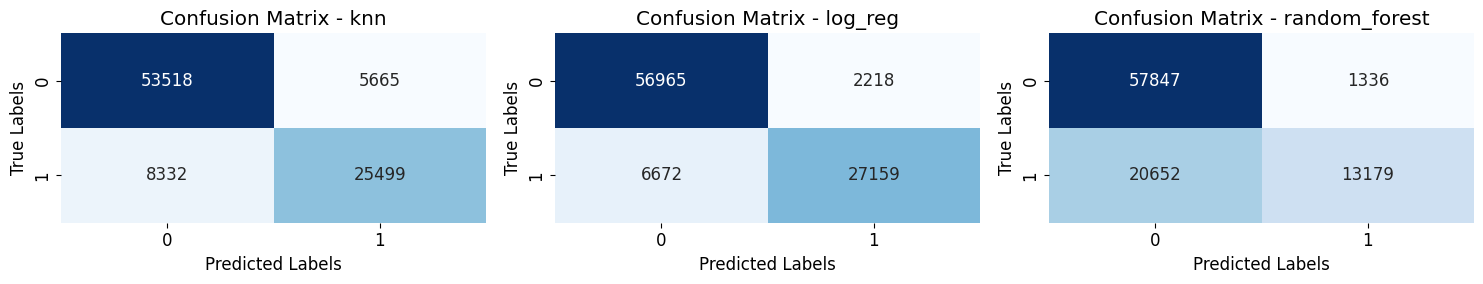

In [22]:
knn.fit(xtrain,ytrain)
log_reg.fit(xtrain,ytrain)
random_forest.fit(xtrain,ytrain)
evaluation_metrics([("knn",knn),("log_reg",log_reg), ("random_forest",random_forest)],xtest,ytest)

      Model  Accuracy Score  Precision Score  Recall Score  F1 Score
0  ensemble            0.89             0.91          0.77      0.83


TypeError: 'Axes' object is not subscriptable

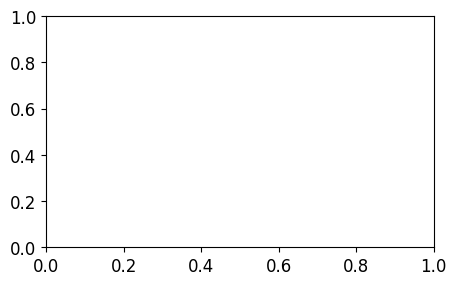

In [26]:
model = VotingClassifier(estimators=[("knn",knn),("log_reg",log_reg), ("random_forest",random_forest)], voting="soft")
model.fit(xtrain,ytrain)
evaluation_metrics([("ensemble", model)],xtest, ytest)
#joblib.dump(model, './utils/pickles/ensemble.joblib')

In [18]:
project = pd.DataFrame([{
    "country": "Germany",
    "goal":100000,
    "category": "Theater",
    "subcategory": "Festivals",
    "launched": "2024-05-24",
    "deadline": "2024-08-25",
    "name":"test",
    "backers":0
}])

print(model.predict(project))
print(model.predict_proba(project))

[0]
[[0.9187444 0.0812556]]
